In [1]:
%load_ext autoreload
%autoreload 2

import dotenv
dotenv.load_dotenv()

from generate_object_candidates import detect, draw_set_of_marks
import matplotlib.pyplot as plt
import transformers
from transformers import pipeline
import PIL.Image
import torch

In [6]:
# get CLIP embedding for the Twix

clip_vision_model = transformers.CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").cuda()
clip_text_model = transformers.CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").cuda()
clip_processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [5]:
# create clip embeddings for objects
@torch.no_grad()
def add_object_clip_embeddings(im1, dets1):
    for det in dets1:
        box = det['box']
        width = box['xmax'] - box['xmin']
        height = box['ymax'] - box['ymin']
        center_x = (box['xmax'] + box['xmin']) / 2
        center_y = (box['ymax'] + box['ymin']) / 2
        # ensure square image to prevent warping
        size = max(224, width, height)
        object_img = im1.crop((center_x-size/2, center_y-size/2, center_x+size/2, center_y+size/2))
        object_emb_output = clip_vision_model(**clip_processor(images=[object_img], return_tensors='pt').to('cuda'))
        object_emb = object_emb_output.image_embeds[0]
        
        det['emb'] = object_emb
        det['desc'] = image_to_text(object_img)


In [4]:
images = [
    PIL.Image.open("sample_images/IMG_8618.jpeg"),
    PIL.Image.open("sample_images/IMG_8619.jpeg"),
    PIL.Image.open("sample_images/IMG_8620.jpeg"),
]


In [5]:
dets = []
for image in images:
    dets_ = detect(image, "candy")
    add_object_clip_embeddings(image, dets_)
    dets.append(dets_)


Detection duration: 3.48


/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Detection duration: 1.66
Detection duration: 1.65


1 0.26352769136428833
2 0.2664819061756134
3 0.29118719696998596


<Figure size 1024x768 with 0 Axes>

<Figure size 1024x768 with 0 Axes>

<Figure size 1024x768 with 0 Axes>

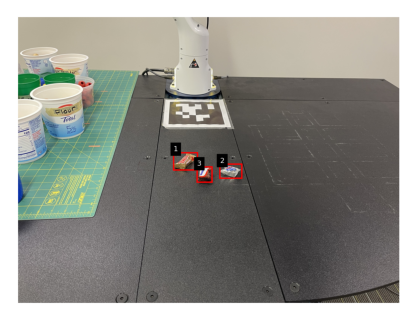

1 0.23629458248615265
2 0.24781495332717896
3 0.24609556794166565
4 0.28577670454978943


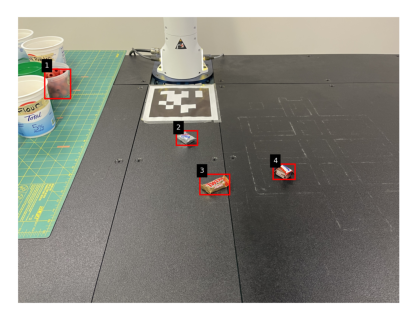

1 0.21733324229717255
2 0.26134756207466125
3 0.2660196125507355
4 0.28888818621635437


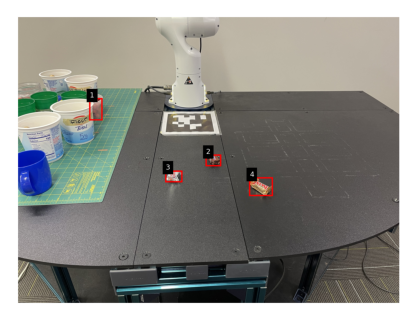

In [6]:
import torch
with torch.no_grad():
    candy_text_emb = clip_text_model(
        **clip_processor(text=['a zoomed-in photo of candy'], return_tensors='pt').to('cuda')
    ).text_embeds[0]
annots = [draw_set_of_marks(image, det) for (image, det) in zip(images, dets)]

for i in range(3):
    fig = plt.figure(dpi=128, figsize=(4, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    ax.imshow(annots[i])
    
    # calculate match scores

    for j in range(len(dets[i])):
        sim = (dets[i][j]['emb'] @ candy_text_emb)/(torch.norm(dets[i][j]['emb'])*torch.norm(candy_text_emb))
        print(j + 1, sim.item())

    plt.show()


## Creating a sample memory bank

Let's create a key-value store.

- Keys: CLIP image embedding, description of the contained information
- Values: Corresponding information
- Queries: CLIP image embeddings

This follows from the Voyager paper from Jim Fan's lab: They store the function's code as values, and natural language descriptions of the functions as keys.

Maybe I could use multiple keys. For example, contextual/linguistic information, as well as object information.

Ideally, memories could be inserted into the prompt, and multimodality could be reasoned with by treating objects or visual representations as variables. This could be useful for context-specific knowledge, but it could also be helpful for general knowledge that the VLM hasn't fully internalized yet.

Example:
```python
memory_1 = Memory("The human doesn't like {variable_1}") # injected by retrieval augmentation

# Choose a candy
candies = scene.detect('candy')
candies = [candy for candy in candies if not similar(candy, memory_1.variable_1)]
```

Side note: Could be nice to have a notion of "privileged instructions" in the memory bank. OpenAI has done some work in this direction. Would just mention as an aside during the retrieval ranking step.

Now, how do items get introduced into the memory bank? Maybe the human provides some instructions like "bring me (X object)". Then the agent reflects on this and creates a `Memory` object.

Should have some better way to select objects than set-of-mark, which in my experience *hasn't* worked very well at all.

Could benefit from a hierarchical memory expansion step, where memories are put deeper in the memory tree if they have lower salience.


In [7]:
# calculate match scores

target = dets[0][2]['emb']
test_dets = dets[1]

for i in range(len(test_dets)):
    sim = (test_dets[i]['emb'] @ target) / (torch.norm(target)*torch.norm(test_dets[i]['emb']))
    print(i + 1, sim.item())


1 0.5719260573387146
2 0.7572999000549316
3 0.7053137421607971
4 0.8741775155067444


## Step 1: Manually Constructing Memories


In [7]:
from memory_bank import PhrasedMemory, Memory, MemoryBank

In [9]:
snickers_emb = dets[0][2]['emb']
memory = PhrasedMemory("The user dislikes {object1}", {"object1": snickers_emb})


How does the LLM get memories introduced?

Should we incorporate them during the object selection step (as metadata for each bounding box) or in the prompt?

Well, I guess we won't know which memories to recall before the LLM makes a plan...

The LLM could think to itself, and then we could retrieve the potentially relevant memories

Additionally, during the object selection stage, we could incorporate it

Should represent the available objects in text form (maybe through a small captioner?) and then inject the metadata corresponding to it

Want to prefer high recall without overestimating the similarity between objects. Maybe we can make a classifier to calibrate whether two embeddings correspond to the same object, and this can be something learned.

## Testing memory recall

Let's see if given a scene, we can accurately recall objects.

I want to rewrite the object selection code because set-of-marks isn't that great. May just try a tiny vit object captioner.


In [10]:
bank = MemoryBank()
bank.add_object_memory(
    Memory(
        object_clip_embedding=snickers_emb,
        salient_information="The user likes this the most"
    )
)

In [14]:
from select_object_v2 import describe_objects_with_retrievals

In [11]:
from select_object_v2 import describe_objects_with_retrievals

print(
    describe_objects_with_retrievals(
        images[1],
        dets[1],
        bank
    )
)


Detections
(1) at (418, 708)
(2) at (1786, 1281)
(3) at (2081, 1770)
(4) at (2814, 1636)
 - Note: This object has a visual similarity score of 0.87 to something which you noted, "The user likes this the most".



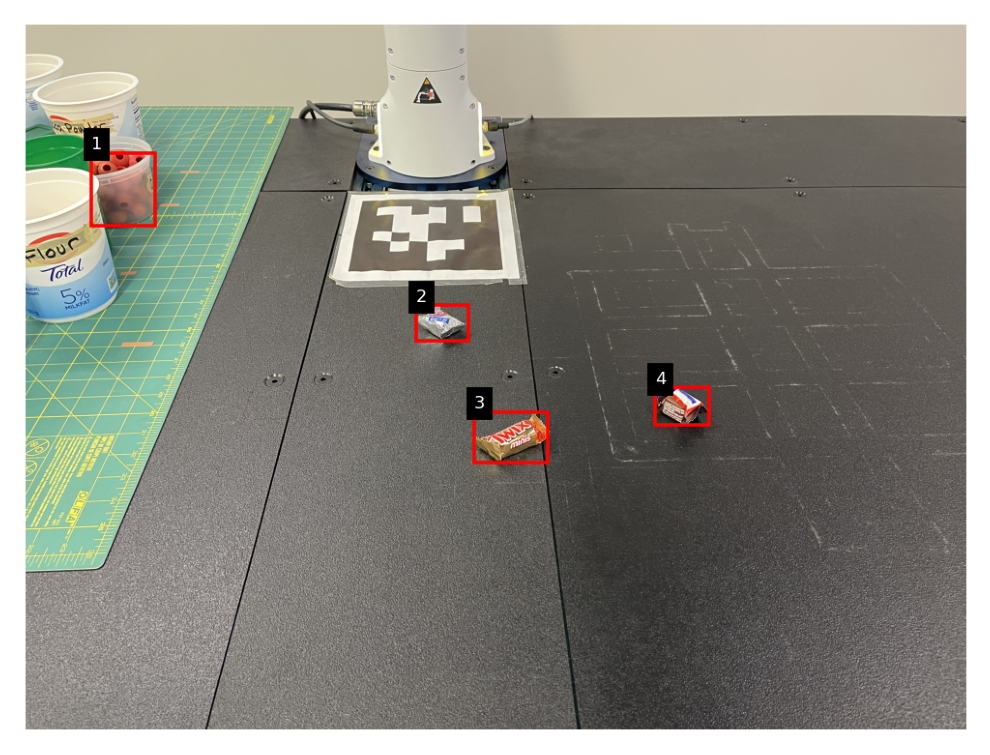

- Object (1) appears to be a container, possibly a small cup with some red details or markings on it. The markings are not clear enough to definitively identify what they are. Since the item does not seem to have the typical appearance of candy and instead resembles a container, it is unlikely to satisfy the user's request for a piece of candy.

- Object (2) is positioned near the edge of the surface and has a rectangular shape with what appears to be a reflective silver-colored wrapper. It is small in size, which is consistent with the size of individual candy pieces. It seems to be a wrapped item, which could indeed be a piece of candy.

- Object (3) is another small, rectangular item with a red and yellow wrapper. The size and shape suggest it could be a piece of candy, which is often sold in such small, individually wrapped packages.

- Object (4) is also small and rectangular with a wrapper that has a red, silver, and what appears to be a blue or purple color scheme. Based on the 

In [27]:
import openai
from vlms import image_message

oai = openai.OpenAI()

object_descriptions = describe_objects_with_retrievals(
    images[1],
    dets[1],
    bank
)
annotated_image = draw_set_of_marks(images[1], dets[1])

plt.imshow(annotated_image)
plt.axis('off')
plt.show()

system_prompt = "You are an intelligent assistant who is highly aligned with the user's preferences."

template = lambda task, label, object_descriptions: f"""
# Task
The user has given the instruction, '{task}'.
You used an object detector to locate '{label}' in an image,
leading to the following detections.

## Detections
{object_descriptions}

## Instructions

Provide a response with the following structure:
- Enumerate each of the objects as they are numbered, describing their visual appearance
in the image in great detail. What visual attributes does this object have?
- Reason about how likely the object is to satisfy the user's request.
- Select the most reasonable object (by number) in the scene.

"""

cmpl = oai.chat.completions.create(
    model='gpt-4-vision-preview',
    messages=[
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': [
            image_message(annotated_image),
            {
                'type': 'text',
                'text': template('get me a piece of candy', 'candy', object_descriptions),
            },
        ]}
    ]
)

print(cmpl.choices[0].message.content)


In [13]:
from groq import Groq

client = Groq()
cmpl = client.chat.completions.create(
    messages=[
        {'role': 'user', 'content': "What is the purpose of life, the universe, and everything? Explain how you arrived at your answer."},
    ],
    model='mixtral-8x7b-32768'
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
print(cmpl.choices[0].message.content)

According to Douglas Adams' science fiction novel "The Hitchhiker's Guide to the Galaxy," the ultimate answer to the ultimate question of life, the universe, and everything is simply the number 42. However, the novel humorously points out that nobody knows what the actual question is.

In a more serious philosophical context, the purpose of life, the universe, and everything has been a topic of debate among scholars, theologians, and philosophers for centuries. There isn't a definitive answer that is universally accepted, as it largely depends on one's personal beliefs and values.

There are various schools of thought on this subject, including:

1. The religious perspective: Many religions propose that the purpose of life is to fulfill a higher spiritual destiny or to serve a divine power. For example, in Christianity, it is commonly believed that the purpose of life is to love and serve God, and to prepare for eternal life.
2. The humanistic perspective: Humanists argue that there is

In [15]:
memory.object1

tensor([ 0.6546, -1.0488,  0.5821,  ..., -0.0339, -2.8398,  0.1282],
       device='cuda:0', grad_fn=<SelectBackward0>)

## Test 2: Decks of cards

Wanting to see if we can manage object memory about a certain deck of cards


In [3]:
cards_images = [
    PIL.Image.open("sample_images/IMG_8624.jpeg"),
    PIL.Image.open("sample_images/IMG_8625.jpeg"),
]

In [4]:
detections = [
    detect(im, 'deck of cards')
    for im in cards_images
]

Detection duration: 4.25
Detection duration: 1.94


In [9]:
add_object_clip_embeddings(cards_images[0], detections[0])
add_object_clip_embeddings(cards_images[1], detections[1])

/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


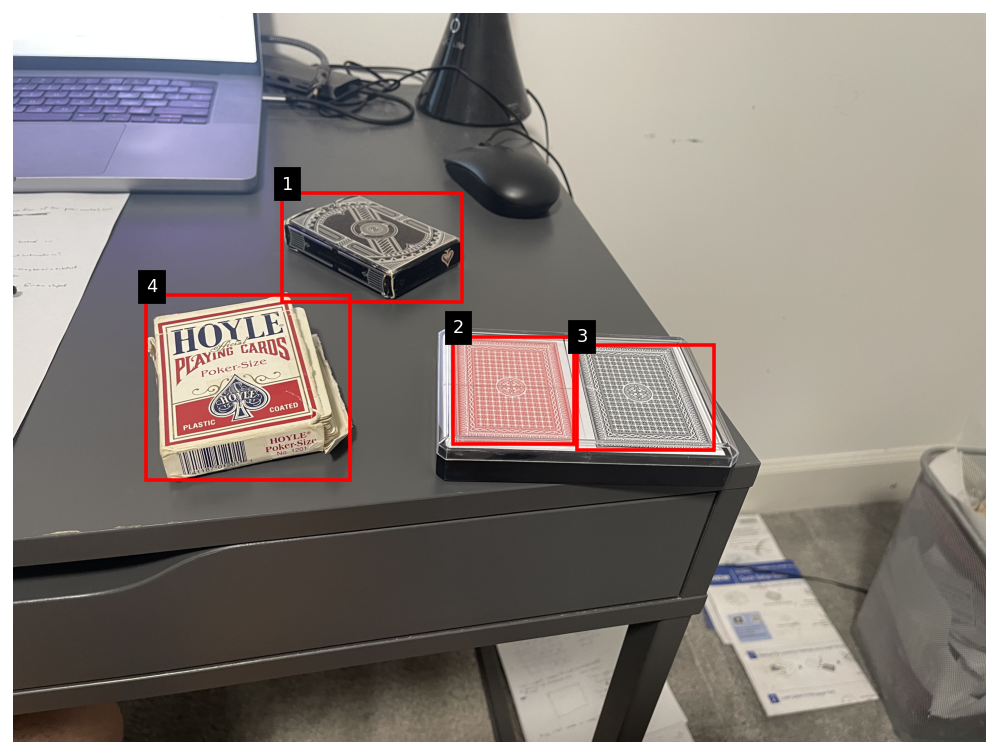

<Figure size 1024x768 with 0 Axes>

In [10]:
draw_set_of_marks(cards_images[0], detections[0])

In [12]:
bank = MemoryBank()

magic_deck_emb = detections[0][0]['emb']

bank.add_object_memory(
    Memory(object_clip_embedding=magic_deck_emb, salient_information="This deck of cards is meant for magic")
)

poker_deck_emb = detections[0][2]['emb']

bank.add_object_memory(
    Memory(object_clip_embedding=poker_deck_emb, salient_information="This deck of cards is meant for poker")
)


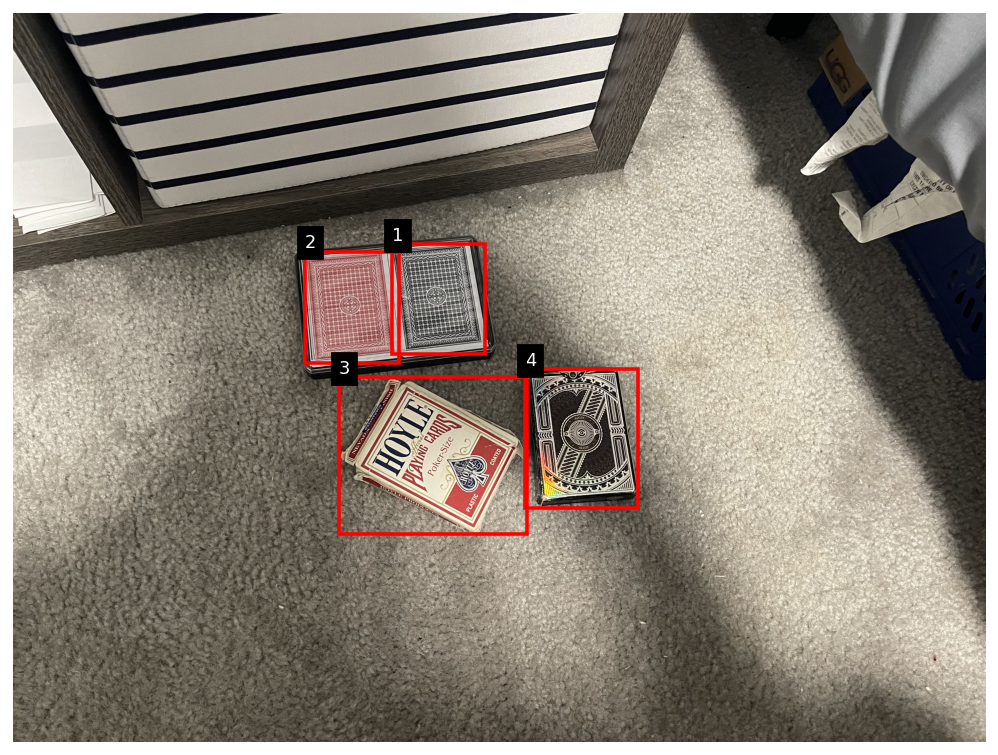

<Figure size 1024x768 with 0 Axes>

In [17]:
draw_set_of_marks(cards_images[1], detections[1])

In [15]:
from select_object_v2 import describe_objects_with_retrievals
print(
    describe_objects_with_retrievals(
        cards_images[1],
        detections[1],
        bank
    )
)

Detections
(1) at (1765, 1187)
 - Note: This object has a visual similarity score of 0.93 to something which you noted, "This deck of cards is meant for poker".
(2) at (1406, 1222)
 - Note: This object has a visual similarity score of 0.80 to something which you noted, "This deck of cards is meant for poker".
(3) at (1741, 1835)
(4) at (2355, 1765)
 - Note: This object has a visual similarity score of 0.83 to something which you noted, "This deck of cards is meant for magic".
 - Note: This object has a visual similarity score of 0.87 to something which you noted, "This deck of cards is meant for poker".



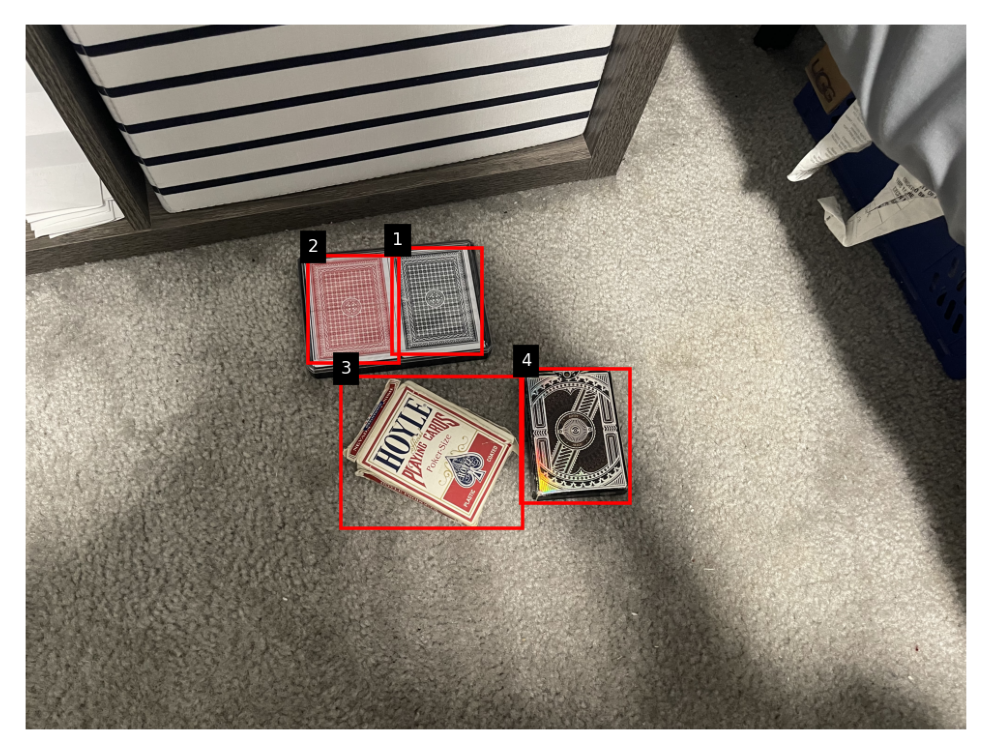

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


- Object 1: This object appears to be a standard deck of playing cards. It is a vertical stack with a red and white pattern on the back. The design has concentric circles near the corners, which is a common feature for playing cards meant for poker. The deck seems to be complete or close to complete, as it is a thick stack.

- Object 2: This is another deck of playing cards, laid horizontally and slightly askew. The back is visible and has a red pattern similar to object 1, implying it may also be ideal for poker. The stack looks slightly less thick than object 1, which could indicate that it's not a full deck.

- Object 3: Here, we see the packaging of a deck of playing cards, specifically "Hoyle" brand, which is known for making cards that can be used for both magic and general card games. As it's only the package without the visible cards, it's unclear whether the deck is inside, making it a risky choice without further inspection.

- Object 4: This deck is spread out, with the face

In [16]:
import openai
from vlms import image_message
from select_object_v2 import describe_objects_with_retrievals

oai = openai.OpenAI()

object_descriptions = describe_objects_with_retrievals(
    cards_images[1],
    detections[1],
    bank
)
annotated_image = draw_set_of_marks(cards_images[1], detections[1])

plt.imshow(annotated_image)
plt.axis('off')
plt.show()

system_prompt = "You are an intelligent assistant who is highly aligned with the user's preferences."

template = lambda task, label, object_descriptions: f"""
# Task
The user has given the instruction, '{task}'.
You used an object detector to locate '{label}' in an image,
leading to the following detections.

## Detections
{object_descriptions}

## Instructions

Provide a response with the following structure:
- Enumerate each of the objects as they are numbered, describing their visual appearance
in the image in great detail. What visual attributes does this object have?
- Reason about how likely the object is to satisfy the user's request.
- Select the most reasonable object (by number) in the scene.

"""

cmpl = oai.chat.completions.create(
    model='gpt-4-vision-preview',
    messages=[
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': [
            image_message(annotated_image),
            {
                'type': 'text',
                'text': template('my friends are over and I want to show a magic trick, give me a deck of cards', 'deck of cards', object_descriptions),
            },
        ]}
    ]
)

print(cmpl.choices[0].message.content)

In [25]:
cmpl = oai.chat.completions.create(
    model='gpt-4-vision-preview',
    messages=[
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': [
            image_message(annotated_image),
            {
                'type': 'text',
                'text': template('my friends are over and I want to play a game, can you hand me a deck of cards?', 'deck of cards', object_descriptions),
            },
        ]}
    ]
)

print(cmpl.choices[0].message.content)

- Object 1 appears to be a standard deck of playing cards, shrink-wrapped, and still in its original packaging. The deck is oriented such that the narrow edge is facing up, and it is positioned on a carpeted floor. The red and blue design on the back of the deck is partially visible through the packaging, suggesting these are conventional poker-sized cards.

- Object 2 looks like another deck of playing cards, this time without any shrink-wrap, suggesting it has been used before. The deck seems complete and is stacked neatly, with the back design showing a red ornate pattern characteristic of traditional playing cards.

- Object 3 is somewhat more difficult to describe as it is mostly obscured by Object 2. It could be a box that typically holds a deck of playing cards, featuring a red and white design with elaborate detailing, including what seems to be a butterfly motif in the center.

- Object 4 is an open deck of playing cards, fanned out so that multiple cards are visible. The desi

In [2]:
import torch
from transformers import AutoModel, AutoTokenizer

# init model and tokenizer
# https://huggingface.co/internlm/internlm-xcomposer2-4khd-7b
model = AutoModel.from_pretrained('internlm/internlm-xcomposer2-4khd-7b', trust_remote_code=True).cuda().eval()
tokenizer = AutoTokenizer.from_pretrained('internlm/internlm-xcomposer2-4khd-7b', trust_remote_code=True)


You are using a model of type internlmxcomposer2 to instantiate a model of type internlm2. This is not supported for all configurations of models and can yield errors.


Set max length to 16384


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of InternLMXComposer2ForCausalLM were not initialized from the model checkpoint at internlm/internlm-xcomposer2-4khd-7b and are newly initialized: ['vit.vision_tower.vision_model.post_layernorm.bias', 'vit.vision_tower.vision_model.post_layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
    query = "<ImageHere>" + system_prompt + "\n" + template('my friends are over and I want to play a game, can you hand me a deck of cards?', 'deck of cards', object_descriptions)
    image = './sample_images/IMG_8625.jpeg'
    with torch.cuda.amp.autocast():
        response, _ = model.chat(tokenizer, query=query, image=image, history=[], do_sample=False)
    print(response)

## Generating Memories

Seems like there is some notion of selectivity in the above example.

Now let's see if we could, purely from a nice user interface, generate the desired memory. At first, the user might ask for a candy. The model should ask for the human's preference by default due to the ambiguity. Over time though, retrieved memories about a user's preferences should boost the model's confidence in a way that can accurately be measured.

### Step 1: introducing the information

On day 1, the human asks for a deck of cards

Because there is no seeming preference between them, we can defer to the human


In [28]:
# start with a blank MemoryBank
bank = MemoryBank()

object_descriptions = describe_objects_with_retrievals(
    cards_images[0],
    detections[0],
    bank
)
annotated_image = draw_set_of_marks(cards_images[0], detections[0])

template = lambda task, label, object_descriptions: f"""
# Task
The user has given the instruction, '{task}'.
You used an object detector to locate '{label}' in an image,
leading to the following detections.

## Detections
{object_descriptions}

## Instructions

Provide a response with the following structure:
- Enumerate each of the objects as they are numbered, describing their visual appearance
in the image in great detail. What visual attributes does this object have?
- Reason about how likely the object is to satisfy the user's request.
- Select the most reasonable object (by number) in the scene.
- Estimate the confidence level you have in your current answer. Note that
  in many cases, you should assume that the human has a preference, and if
  you do not know what it is, you should ask for the human's choice.

If you want to defer to the human, say "defer to human" at the end of your message.
"""

cmpl = oai.chat.completions.create(
    model='gpt-4-vision-preview',
    messages=[
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': [
            image_message(annotated_image),
            {
                'type': 'text',
                'text': template('my friends are over and I want to play a game, can you hand me a deck of cards?', 'deck of cards', object_descriptions),
            },
        ]}
    ]
)

print(cmpl.choices[0].message.content)

- Object (1) is what appears to be a single playing card lying face down on the corner of the desk. The back of the card has a decorative design, predominantly black with white and red details. This single card is unlikely to satisfy the user's request for a deck of cards, as it's only one card and not a full deck.

- Object (2) is a deck of playing cards in a red box, which lies on top of another deck of playing cards with a blue back design. The red box has an intricate pattern, and it seems to be closed. This set satisfies the user's request as it appears to be a complete deck of cards suitable for playing various card games.

- Object (3) is a deck of playing cards in a closed box. The box is predominantly silver or grey with a geometric design and appears unopened. Like object (2), this is also a complete deck that would be suitable for playing card games.

- Object (4) is a wrapped deck of playing cards with the brand name "HOYLE" visible, and mentioned as 'Poker Size' and 'Plast

<Figure size 1024x768 with 0 Axes>

In [29]:
# represent choice of object (3)

bank.add_object_memory(
    Memory(
        object_clip_embedding=detections[0][2]['emb'],
        salient_information="This was the human's choice of cards to play poker with"
    )
)


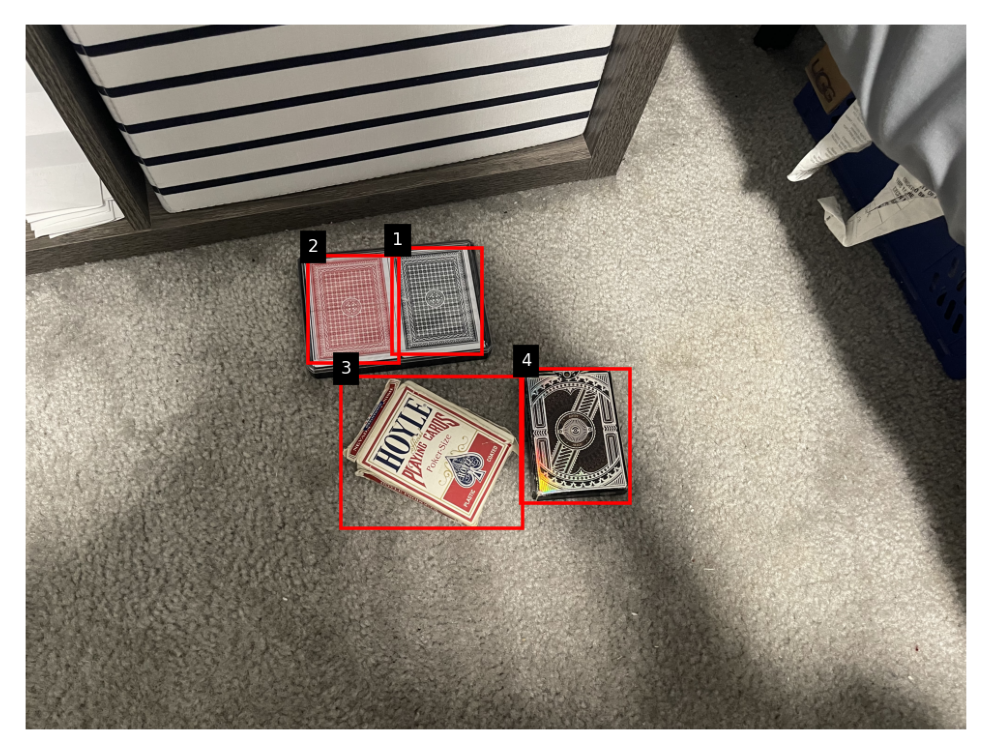

Detections
(1) at (1765, 1187)
 - Note: This object has a visual similarity score of 0.93 to something which you noted, "This was the human's choice of cards to play poker with".
(2) at (1406, 1222)
 - Note: This object has a visual similarity score of 0.80 to something which you noted, "This was the human's choice of cards to play poker with".
(3) at (1741, 1835)
(4) at (2355, 1765)
 - Note: This object has a visual similarity score of 0.87 to something which you noted, "This was the human's choice of cards to play poker with".

- Object 1: This object appears as a stack of cards with backs visible, showing a blue and black circular pattern with intricate details toward the center and a symmetrical design along the edges. It looks like a standard deck of playing cards in its case and is positioned in a way that suggests it's a complete and ready-to-use deck.

- Object 2: This is another stack of cards, with the top card's back visible. It has a red and white pattern, predominantly fea

In [30]:
## new day, new setup ##

object_descriptions = describe_objects_with_retrievals(
    cards_images[1],
    detections[1],
    bank
)
annotated_image = draw_set_of_marks(cards_images[1], detections[1])

plt.imshow(annotated_image)
plt.axis('off')
plt.show()

print(object_descriptions)

template = lambda task, label, object_descriptions: f"""
# Task
The user has given the instruction, '{task}'.
You used an object detector to locate '{label}' in an image,
leading to the following detections.

## Detections
{object_descriptions}

## Instructions

Provide a response with the following structure:
- Enumerate each of the objects as they are numbered, describing their visual appearance
in the image in great detail. What visual attributes does this object have?
- Reason about how likely the object is to satisfy the user's request.
- Select the most reasonable object (by number) in the scene.
- Estimate the confidence level you have in your current answer. Note that
  in many cases, you should assume that the human has a preference, and if
  you do not know what it is, you should ask for the human's choice.

If you want to defer to the human, say "defer to human" at the end of your message.
"""

cmpl = oai.chat.completions.create(
    model='gpt-4-vision-preview',
    messages=[
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': [
            image_message(annotated_image),
            {
                'type': 'text',
                'text': template('my friends are over and I want to play a game, can you hand me a deck of cards?', 'deck of cards', object_descriptions),
            },
        ]}
    ]
)

print(cmpl.choices[0].message.content)